# Task 3: Feature importances in random forest classifiers

In [1]:
#IMPORTS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [2]:
train_data = pd.read_csv('adult_train.csv')
test_data = pd.read_csv('adult_test.csv')
X_train_dict = train_data.iloc[:,:-1].to_dict('records')
print(X_train_dict[0])
Y_train = train_data.iloc[:,-1:]
X_test_dict = test_data.iloc[:,:-1].to_dict('records')
Y_test = test_data.iloc[:,-1:]

{'age': 27, 'workclass': 'Private', 'education': 'Some-college', 'education-num': 10, 'marital-status': 'Divorced', 'occupation': 'Adm-clerical', 'relationship': 'Unmarried', 'race': 'White', 'sex': 'Female', 'capital-gain': 0, 'capital-loss': 0, 'hours-per-week': 44, 'native-country': 'United-States'}


In [3]:
vect = DictVectorizer()
X_train_vec = vect.fit_transform(X_train_dict)
X_test_vec = vect.transform(X_test_dict)
vect.get_feature_names_out()


array(['age', 'capital-gain', 'capital-loss', 'education-num',
       'education=10th', 'education=11th', 'education=12th',
       'education=1st-4th', 'education=5th-6th', 'education=7th-8th',
       'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc',
       'education=Bachelors', 'education=Doctorate', 'education=HS-grad',
       'education=Masters', 'education=Preschool',
       'education=Prof-school', 'education=Some-college',
       'hours-per-week', 'marital-status=Divorced',
       'marital-status=Married-AF-spouse',
       'marital-status=Married-civ-spouse',
       'marital-status=Married-spouse-absent',
       'marital-status=Never-married', 'marital-status=Separated',
       'marital-status=Widowed', 'native-country=?',
       'native-country=Cambodia', 'native-country=Canada',
       'native-country=China', 'native-country=Columbia',
       'native-country=Cuba', 'native-country=Dominican-Republic',
       'native-country=Ecuador', 'native-country=El-Salvador',

We have got some ordinal cateegorical varialbes (education?)+ nominal categorical (native country, occupation, race), binary variables (sex maybe nominal categorical but we can discuss) and no numerical (no discrete or continuos), this is a classification task. WE can select f_classif ,mutual info class_and chi2 score. 

WE NEED TO SELECT APPROPRIATE SCORING FUNCTIONS 

f_classif
ANOVA F-value between label/feature for classification tasks.

mutual_info_classif
Mutual information for a discrete target.

chi2
Chi-squared stats of non-negative features for classification tasks.

f_regression
F-value between label/feature for regression tasks.

mutual_info_regression
Mutual information for a continuous target.

SelectPercentile
Select features based on percentile of the highest scores.

SelectFpr
Select features based on a false positive rate test.

SelectFdr
Select features based on an estimated false discovery rate.

SelectFwe
Select features based on family-wise error rate.

GenericUnivariateSelect
Univariate feature selector with configurable mode.

In [4]:
# Mutual Info
from sklearn.feature_selection import mutual_info_classif

feature_scores_mutual_info = mutual_info_classif(X_train_vec, Y_train)

for score, fname in sorted(zip(feature_scores_mutual_info, vect.get_feature_names_out()), reverse=True)[:10]:
    print(fname, score)


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
marital-status=Married-civ-spouse 0.10543223425356207
capital-gain 0.08338237212343572
relationship=Husband 0.08087684110742101
age 0.06877253967893691
education-num 0.06487222762680706
marital-status=Never-married 0.06195072410418583
hours-per-week 0.0422833222022355
relationship=Own-child 0.038216104202734365
capital-loss 0.036980484510352706
sex=Male 0.02576524240037431


In [5]:
#F-statistic- ANOVA test.
from sklearn.feature_selection import f_classif

feature_scores_f_classif = f_classif(X_train_vec, Y_train)[0]

for score, fname in sorted(zip(feature_scores_f_classif, vect.get_feature_names_out()), reverse=True)[:10]:
    print(fname, score)

marital-status=Married-civ-spouse 8025.8420615949835
relationship=Husband 6240.018276214241
education-num 4120.095779707474
marital-status=Never-married 3674.2001465697413
age 1886.7073137161203
hours-per-week 1813.3862822161334
relationship=Own-child 1794.1574893573925
capital-gain 1709.150063743795
sex=Female 1593.1079074467164
sex=Male 1593.1079074467073
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# χ^2 statistical test.
from sklearn.feature_selection import chi2

feature_scores_chi2 = chi2(X_train_vec, Y_train)[0]

for score, fname in sorted(zip(feature_scores_chi2, vect.get_feature_names_out()), reverse=True)[:10]:
    print(fname, score)

capital-gain 82192467.14154437
capital-loss 1372145.890201465
age 8600.61182155558
hours-per-week 6476.4089959321245
marital-status=Married-civ-spouse 3477.5158774537117
relationship=Husband 3114.94154602898
education-num 2401.4217771976464
marital-status=Never-married 2218.5219765707857
relationship=Own-child 1435.873016044718
occupation=Exec-managerial 1315.4826322279757


In [12]:
feature_names = [f"feature {i}" for i in range(X_train_vec.shape[1])]
rfc = RandomForestClassifier()
rfc.fit(X_train_vec, Y_train)
y_pred_train = rfc.predict(X_train_vec)
print(accuracy_score(Y_train, y_pred_train))

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)


print(importances)



/tmp/ipykernel_189/1553286150.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train_vec, Y_train)
0.976413500813857
[2.30062397e-01 1.02166601e-01 3.49850627e-02 6.72437806e-02
 1.74006900e-03 2.04470059e-03 9.42520801e-04 3.55859627e-04
 7.20144961e-04 2.16068419e-03 1.39758441e-03 2.57908897e-03
 3.21408106e-03 1.18076913e-02 4.19729559e-03 7.98671894e-03
 8.13959098e-03 6.81002777e-05 5.22158663e-03 5.61000419e-03
 1.15808163e-01 6.84393073e-03 4.16082118e-04 6.70825950e-02
 1.02579795e-03 2.70279111e-02 1.80127499e-03 1.63192487e-03
 3.04905656e-03 3.47330240e-04 1.17064379e-03 5.45412438e-04
 2.37675624e-04 7.70543304e-04 1.64850204e-04 1.60334640e-04
 2.50067900e-04 9.89686669e-04 3.24158758e-04 1.27658363e-03
 3.81710664e-04 1.50951189e-04 1.60810771e-04 0.00000000e+00
 1.00115342e-05 1.76423109e-04 1.59576642e-04 7.79260721e-04
 4.68803007e-04 2.05875832e

In [26]:
dict_arr = {i: importances[i] for i in range(len(importances))}
sorted_dict = dict(sorted(dict_arr.items(), key=lambda item: item[1], reverse=True))


feature_names_str = []
first_ten_important_features = []
for i, (key, value) in enumerate(sorted_dict.items()):
    if i == 10:
        break
    feature_names_str.append(list(X_train_dict[0].keys())[i])
    first_ten_important_features.append(value)
    print(list(X_train_dict[0].keys())[i], value)






age 0.23006239689724375
workclass 0.1158081630607369
education 0.10216660131440246
education-num 0.0672437806142014
marital-status 0.06708259501384731
occupation 0.043053862769192805
relationship 0.03498506266309046
race 0.02702791109319724
sex 0.022659794536000557
capital-gain 0.015521334133752295


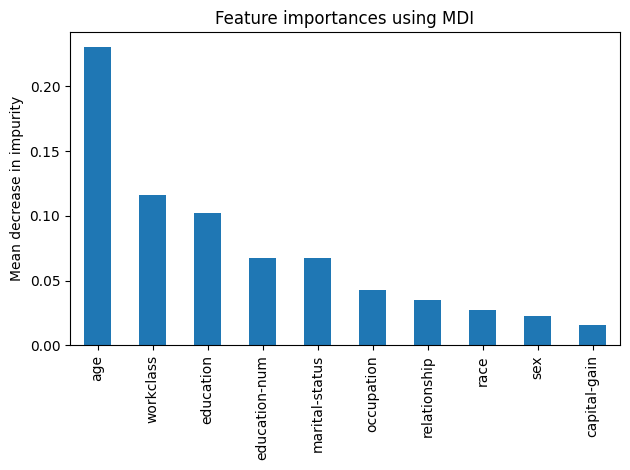

In [30]:
forest_importances = pd.Series(first_ten_important_features, index=feature_names_str)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax) #
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

TODO

- Expain what is feature_importance_, f_classif , mutual_info_classif and chi2

- Explain the first 10 important features


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e2e8444-e1fc-4224-9943-b161fccfd54d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>